In [2]:
!nvidia-smi

Tue May 26 15:39:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   26C    P8    13W / 250W |  10710MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   24C    P8     6W / 250W |  10831MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [4]:
neg_path = load_path('train', 'n', 'neg', data = 'sm_x160')
redspot_path = load_path('train', 'h', 'redspot', data = 'sm_x160')
angio_path = load_path('train', 'h', 'angio', data = 'sm_x160')
active_path = load_path('train', 'h', 'active', data = 'sm_x160')
ero_path = load_path('train', 'd', 'ero', data = 'sm_x160')
ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm_x160')
str_path = load_path('train', 'd', 'str', data = 'sm_x160')

print("negative:",neg_path.shape)
print("red spot:",redspot_path.shape)
print("angioectasia:",angio_path.shape)
print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (1017120,)
red spot: (92960,)
angioectasia: (3200,)
active_bleeding: (66240,)
erosion: (128160,)
ulcer: (123840,)
stricture: (15680,)


In [5]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
angio_train_path, angio_valid_path = train_valid_split(angio_path)
active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (864552,) (129496,)
red spot: (79016,) (11841,)
angioectasia: (2720,) (412,)
active bleeding: (56304,) (8375,)
erosion: (108936,) (16320,)
ulcer: (105264,) (15764,)
stricture: (13328,) (2002,)


# Model

In [6]:
input_h = 512
input_w = 512
input_ch = 3

k_chs = [16, 16, 16, 32, 32, 32, 64]
n_conv_block = len(k_chs)
n_hid_node = [100, 50]
n_hid_layer = len(n_hid_node)
n_output = 2

In [7]:
class CE_cnn:
    def __init__(self, k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output):
        self.k_chs = k_chs
        self.n_conv_block = n_conv_block
        self.n_hid_node = n_hid_node
        self.n_hid_layer = n_hid_layer
        self.n_output = n_output
    def conv_block(self, x, k_chs, n_conv_block):
        for i in range(1, n_conv_block + 1):
            if i == 1:
                conv = tf.layers.conv2d(inputs = x, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            else:
                conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                    activation= tf.nn.relu, name = 'block_{}_conv_2'.format(i))
            conv = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2, name = 'block_{}_maxp'.format(i))
        return conv
    def fc_layers(self, x, n_hid_node, n_hid_layer, n_output):
        hidden = tf.layers.flatten(x)
        for i in range(1, n_hid_layer + 1):
            hidden = tf.layers.dense(inputs = hidden, units = n_hid_node[i-1],activation = tf.nn.relu, name = 'fc_{}'.format(i))
            hidden = tf.layers.dropout(hidden, rate = 0.3, training = is_training)
        score = tf.layers.dense(inputs = hidden, units = n_output, name = 'score')
        return score
    
    def inf(self, x):
        conv = self.conv_block(x, self.k_chs, self.n_conv_block)
        score = self.fc_layers(conv, self.n_hid_node, self.n_hid_layer, self.n_output)
        return score

In [8]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
is_training = tf.placeholder(tf.bool, name = 'is_training')
LR = tf.placeholder(tf.float32)

model = CE_cnn(k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0526 15:40:24.387290 140543087904512 deprecation.py:323] From <ipython-input-7-147423120551>:12: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0526 15:40:24.392028 140543087904512 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0526 15:40:24.606038 140543087904512 deprecation.py:323] From <ipython-input-7-147423120551>:18: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0526 15:40:24.892659 140543087904512 deprecation.py:323] F

# Training

damped_exp_LR(40000, alpha = 0.00005) <br>
n_batch (per class) = 50  <br>
cal_interval = 10 <br>
prt_interval = 100 <br>

In [9]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

a_train_path = np.hstack([h_train_path, d_train_path])
a_valid_path = np.hstack([h_valid_path, d_valid_path])

a_train_path = shuffle(a_train_path, None)
a_valid_path = shuffle(a_valid_path, None)

In [10]:
damped_exp_LR

<function ce_utils.damped_exp_LR(n_iter, f=20, A=0.0005, alpha=0.0002, gamma=0.1)>

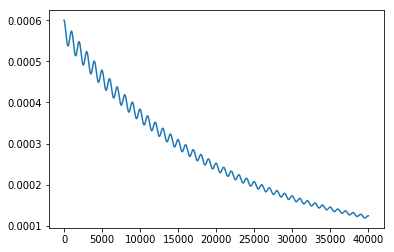

In [11]:
D_lr = damped_exp_LR(40000, alpha = 0.00005)

plt.plot(D_lr)

## training negative images: 254,280 (x40)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 59.00 %    || 57.00 %    || 0.67090821 || 0.68443733
--------------------------------------------------------------


W0526 15:44:28.859574 140543087904512 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*200] || 79.00 %    || 75.00 %    || 0.61697292 || 0.62988997
--------------------------------------------------------------
[*300] || 85.00 %    || 82.00 %    || 0.41452396 || 0.40050659
--------------------------------------------------------------
[*400] || 88.00 %    || 85.00 %    || 0.27848178 || 0.32708922
--------------------------------------------------------------
[*500] || 89.00 %    || 91.00 %    || 0.29373419 || 0.29427329
--------------------------------------------------------------
[*600] || 86.00 %    || 85.00 %    || 0.30840033 || 0.31191856
--------------------------------------------------------------
[*700] || 84.00 %    || 89.00 %    || 0.39317402 || 0.31272924
--------------------------------------------------------------
[*800] || 80.00 %    || 80.00 %    || 0.36311725 || 0.38858783
--------------------------------------------------------------
[*900] || 93.00 %    || 86.00 %    || 0.22431019 || 0.35711628
-------------------------------------------------------

[6800] || 94.00 %    || 98.00 %    || 0.12937482 || 0.09401079
--------------------------------------------------------------
[6900] || 95.00 %    || 91.00 %    || 0.16045579 || 0.20195384
--------------------------------------------------------------
[7000] || 94.00 %    || 93.00 %    || 0.15135756 || 0.18395096
--------------------------------------------------------------
[7100] || 94.00 %    || 97.00 %    || 0.18562421 || 0.10755549
--------------------------------------------------------------
[7200] || 91.00 %    || 93.00 %    || 0.17805883 || 0.16954716
--------------------------------------------------------------
[7300] || 96.00 %    || 92.00 %    || 0.15630844 || 0.15783328
--------------------------------------------------------------
[7400] || 97.00 %    || 93.00 %    || 0.06375282 || 0.15681125
--------------------------------------------------------------
[7500] || 93.00 %    || 91.00 %    || 0.16292427 || 0.21169642
-------------------------------------------------------

[13300] || 98.00 %    || 96.00 %    || 0.07277413 || 0.09912403
--------------------------------------------------------------
[13400] || 99.00 %    || 99.00 %    || 0.04024334 || 0.07536002
--------------------------------------------------------------
[13500] || 97.00 %    || 95.00 %    || 0.07429514 || 0.12672560
--------------------------------------------------------------
[13600] || 99.00 %    || 96.00 %    || 0.05553676 || 0.06032024
--------------------------------------------------------------
[13700] || 99.00 %    || 97.00 %    || 0.04051970 || 0.05823876
--------------------------------------------------------------
[13800] || 98.00 %    || 94.00 %    || 0.07654268 || 0.10451654
--------------------------------------------------------------
[13900] || 97.00 %    || 96.00 %    || 0.12281444 || 0.11126208
--------------------------------------------------------------
[14000] || 97.00 %    || 99.00 %    || 0.09103393 || 0.06348813
-----------------------------------------------

[19800] || 99.00 %    || 99.00 %    || 0.02374686 || 0.03135029
--------------------------------------------------------------
[19900] || 97.00 %    || 97.00 %    || 0.11230381 || 0.07663868
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.01438395 || 0.02634192
--------------------------------------------------------------
[20100] || 100.00 %    || 98.00 %    || 0.01509031 || 0.04091609
--------------------------------------------------------------
[20200] || 99.00 %    || 99.00 %    || 0.05493227 || 0.02083775
--------------------------------------------------------------
[20300] || 100.00 %    || 98.00 %    || 0.01403436 || 0.07234731
--------------------------------------------------------------
[20400] || 99.00 %    || 99.00 %    || 0.06456038 || 0.03845540
--------------------------------------------------------------
[20500] || 99.00 %    || 98.00 %    || 0.03761882 || 0.05686734
-------------------------------------------

[26300] || 100.00 %    || 100.00 %    || 0.01207447 || 0.00526949
--------------------------------------------------------------
[26400] || 98.00 %    || 95.00 %    || 0.06105207 || 0.06607357
--------------------------------------------------------------
[26500] || 100.00 %    || 99.00 %    || 0.00516842 || 0.01630600
--------------------------------------------------------------
[26600] || 100.00 %    || 98.00 %    || 0.01139829 || 0.05530146
--------------------------------------------------------------
[26700] || 99.00 %    || 99.00 %    || 0.05064817 || 0.03398172
--------------------------------------------------------------
[26800] || 97.00 %    || 97.00 %    || 0.05038645 || 0.05077362
--------------------------------------------------------------
[26900] || 100.00 %    || 100.00 %    || 0.01619697 || 0.01306748
--------------------------------------------------------------
[27000] || 100.00 %    || 98.00 %    || 0.01066635 || 0.06035246
----------------------------------------

[32800] || 99.00 %    || 99.00 %    || 0.02838591 || 0.01921487
--------------------------------------------------------------
[32900] || 99.00 %    || 97.00 %    || 0.03834578 || 0.19158672
--------------------------------------------------------------
[33000] || 99.00 %    || 98.00 %    || 0.01161004 || 0.13925448
--------------------------------------------------------------
[33100] || 100.00 %    || 98.00 %    || 0.01536686 || 0.05065151
--------------------------------------------------------------
[33200] || 99.00 %    || 98.00 %    || 0.03881735 || 0.02976793
--------------------------------------------------------------
[33300] || 100.00 %    || 100.00 %    || 0.00824603 || 0.01453881
--------------------------------------------------------------
[33400] || 100.00 %    || 97.00 %    || 0.01107900 || 0.05713987
--------------------------------------------------------------
[33500] || 100.00 %    || 96.00 %    || 0.01487475 || 0.05710946
------------------------------------------

[39300] || 99.00 %    || 99.00 %    || 0.03843398 || 0.05009285
--------------------------------------------------------------
[39400] || 100.00 %    || 100.00 %    || 0.00351438 || 0.00306650
--------------------------------------------------------------
[39500] || 99.00 %    || 100.00 %    || 0.01547577 || 0.00774210
--------------------------------------------------------------
[39600] || 100.00 %    || 100.00 %    || 0.01509292 || 0.01078773
--------------------------------------------------------------
[39700] || 100.00 %    || 97.00 %    || 0.00140859 || 0.05092755
--------------------------------------------------------------
[39800] || 100.00 %    || 98.00 %    || 0.01053136 || 0.05484878
--------------------------------------------------------------
[39900] || 99.00 %    || 100.00 %    || 0.02123332 || 0.00544353
--------------------------------------------------------------
[40000] || 99.00 %    || 99.00 %    || 0.01788311 || 0.03261995
---------------------------------------

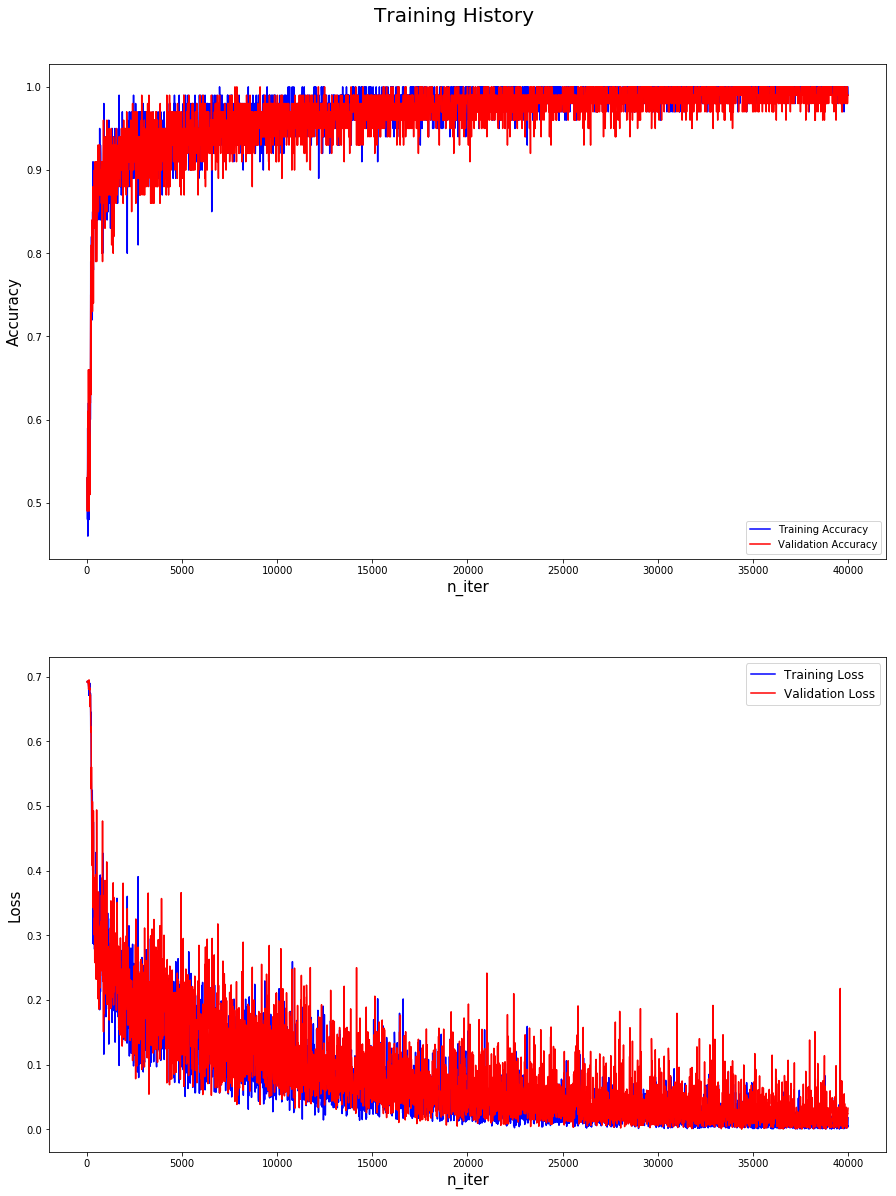

In [12]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/x160_rev/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## training negative images: 50,856 (x8)

In [21]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_NX8A_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 58.00 %    || 55.00 %    || 0.67450851 || 0.68616557
--------------------------------------------------------------
[*200] || 67.00 %    || 67.00 %    || 0.54843771 || 0.55160499
--------------------------------------------------------------
[*300] || 68.00 %    || 70.00 %    || 0.52406579 || 0.51885915
--------------------------------------------------------------
[*400] || 75.00 %    || 77.00 %    || 0.48262417 || 0.48868087
--------------------------------------------------------------
[*500] || 90.00 %    || 90.00 %    || 0.28635859 || 0.29721814
--------------------------------------------------------------
[*600] || 84.00 %    || 75.00 %    || 0.36871886 || 0.46607947
--------------------------------------------------------------
[*700] || 93.00 %    || 83.00 %    || 0.24895266 || 0.33748665
--------------------------------------------------------------
[*800] || 93.00 %    || 95.00 %    || 0.15694854 || 0.1

[6500] || 97.00 %    || 99.00 %    || 0.11522818 || 0.03979044
--------------------------------------------------------------
[6600] || 96.00 %    || 98.00 %    || 0.11933930 || 0.05617368
--------------------------------------------------------------
[6700] || 99.00 %    || 99.00 %    || 0.02613086 || 0.06312186
--------------------------------------------------------------
[6800] || 100.00 %    || 98.00 %    || 0.00966164 || 0.03442097
--------------------------------------------------------------
[6900] || 96.00 %    || 98.00 %    || 0.13205314 || 0.06525434
--------------------------------------------------------------
[7000] || 99.00 %    || 100.00 %    || 0.05381805 || 0.01932300
--------------------------------------------------------------
[7100] || 100.00 %    || 99.00 %    || 0.00792241 || 0.03731135
--------------------------------------------------------------
[7200] || 98.00 %    || 99.00 %    || 0.06959870 || 0.04795228
----------------------------------------------------

[13000] || 99.00 %    || 99.00 %    || 0.01991029 || 0.04964466
--------------------------------------------------------------
[13100] || 97.00 %    || 100.00 %    || 0.04568261 || 0.01844819
--------------------------------------------------------------
[13200] || 100.00 %    || 99.00 %    || 0.00324798 || 0.04484899
--------------------------------------------------------------
[13300] || 99.00 %    || 96.00 %    || 0.02377326 || 0.08722650
--------------------------------------------------------------
[13400] || 98.00 %    || 99.00 %    || 0.02639554 || 0.03616453
--------------------------------------------------------------
[13500] || 100.00 %    || 98.00 %    || 0.00719299 || 0.07034962
--------------------------------------------------------------
[13600] || 99.00 %    || 99.00 %    || 0.01390287 || 0.06286237
--------------------------------------------------------------
[13700] || 99.00 %    || 99.00 %    || 0.03724178 || 0.03909554
--------------------------------------------

[19500] || 99.00 %    || 100.00 %    || 0.07073104 || 0.00407836
--------------------------------------------------------------
[19600] || 100.00 %    || 100.00 %    || 0.00708122 || 0.00418504
--------------------------------------------------------------
[19700] || 98.00 %    || 99.00 %    || 0.05879707 || 0.04329382
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00283458 || 0.00400776
--------------------------------------------------------------
[19900] || 100.00 %    || 99.00 %    || 0.00222316 || 0.06767574
--------------------------------------------------------------
[20000] || 99.00 %    || 100.00 %    || 0.03263348 || 0.00346245
--------------------------------------------------------------
[20100] || 100.00 %    || 99.00 %    || 0.00615947 || 0.06324779
--------------------------------------------------------------
[20200] || 100.00 %    || 100.00 %    || 0.00129413 || 0.00222596
-------------------------------------

[25900] || 100.00 %    || 100.00 %    || 0.00051078 || 0.00128406
--------------------------------------------------------------
[26000] || 100.00 %    || 100.00 %    || 0.00280254 || 0.00051421
--------------------------------------------------------------
[26100] || 99.00 %    || 100.00 %    || 0.04061775 || 0.00216308
--------------------------------------------------------------
[26200] || 99.00 %    || 100.00 %    || 0.05309975 || 0.00252205
--------------------------------------------------------------
[26300] || 99.00 %    || 100.00 %    || 0.01548912 || 0.00364813
--------------------------------------------------------------
[26400] || 100.00 %    || 98.00 %    || 0.00754079 || 0.11340332
--------------------------------------------------------------
[26500] || 100.00 %    || 100.00 %    || 0.00114870 || 0.00165781
--------------------------------------------------------------
[26600] || 99.00 %    || 99.00 %    || 0.03626372 || 0.02391312
-------------------------------------

[32300] || 100.00 %    || 99.00 %    || 0.00153898 || 0.07270228
--------------------------------------------------------------
[32400] || 100.00 %    || 100.00 %    || 0.00066478 || 0.00227499
--------------------------------------------------------------
[32500] || 100.00 %    || 100.00 %    || 0.00107506 || 0.00515321
--------------------------------------------------------------
[32600] || 100.00 %    || 100.00 %    || 0.00194620 || 0.00521254
--------------------------------------------------------------
[32700] || 100.00 %    || 100.00 %    || 0.00273991 || 0.00065239
--------------------------------------------------------------
[32800] || 100.00 %    || 99.00 %    || 0.00093513 || 0.07980104
--------------------------------------------------------------
[32900] || 100.00 %    || 99.00 %    || 0.00069663 || 0.05263230
--------------------------------------------------------------
[33000] || 100.00 %    || 100.00 %    || 0.00074532 || 0.00886759
----------------------------------

KeyboardInterrupt: 

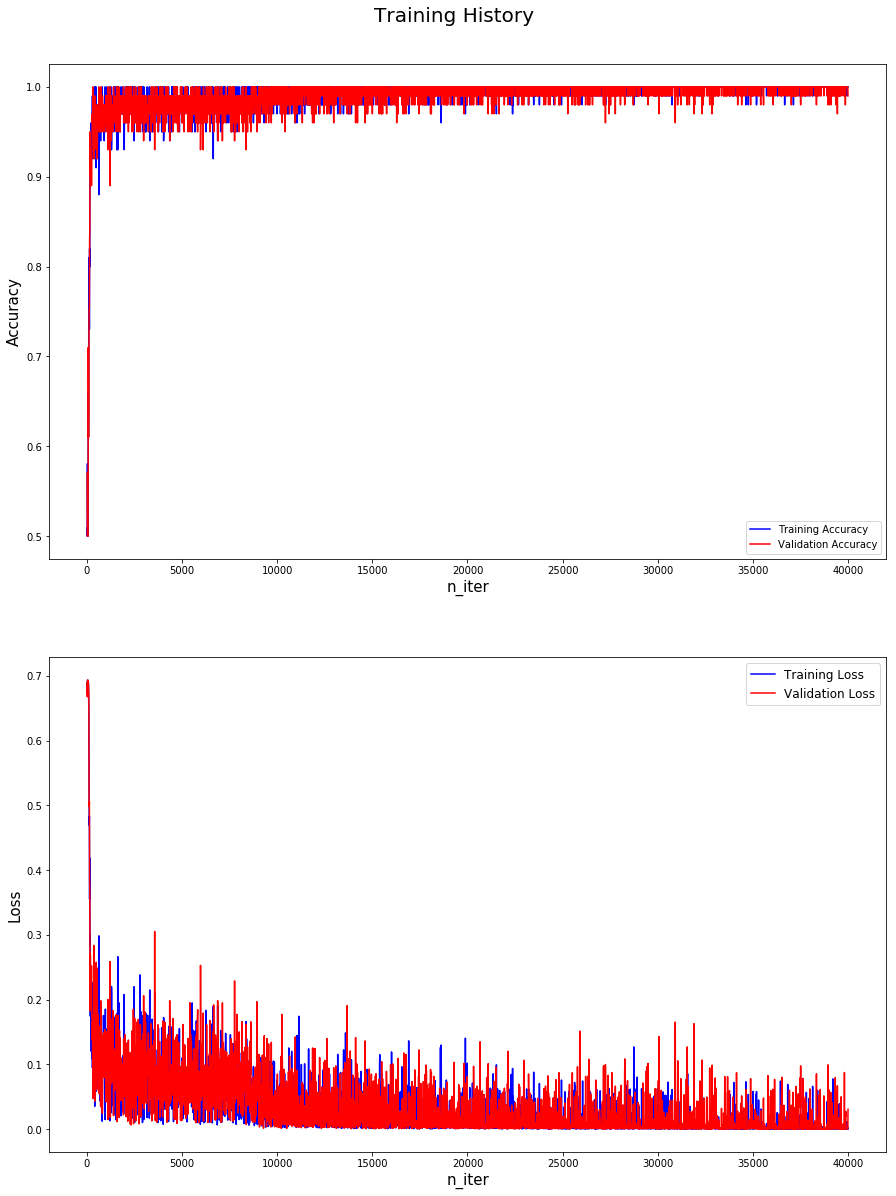

In [12]:
hist.plot(cal_interval)   